In [231]:
import pandas as pd
import requests
import datetime as dt
import time
import re

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
import spacy.cli

import contractions
import unicodedata
import string

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [151]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

In [152]:
parent_askscience=pd.read_csv('./datasets/askscience/submissions.csv')

In [153]:
parent_askengineers=pd.read_csv('./datasets/askengineers/submissions.csv',nrows=5074)

In [154]:
parent_askscience.shape, parent_askengineers.shape

((5074, 102), (5074, 80))

In [155]:
parent_askscience.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_text', 'author_flair_text_color',
       'author_flair_type', 'author_fullname',
       ...
       'can_gild', 'hidden', 'media', 'quarantine', 'secure_media',
       'subreddit_name_prefixed', 'rte_mode', 'author_id', 'brand_safe',
       'previous_visits'],
      dtype='object', length=102)

In [156]:
#picking some features that might be interesting to explore
features=['created_utc','id','author','num_comments','score','selftext','subreddit','title']

In [157]:
askscience_df=parent_askscience[features].copy()
askengineers_df=parent_askengineers[features].copy()
askscience_df.shape, askengineers_df.shape

((5074, 8), (5074, 8))

In [158]:
askscience_df['subreddit'].value_counts()

askscience    5074
Name: subreddit, dtype: int64

In [159]:
askengineers_df['subreddit'].value_counts()

AskEngineers    5074
Name: subreddit, dtype: int64

In [160]:
askscience_df.head()

created_utc      id               author  num_comments  score  \
0   1663962461  xm7a6n           bmarcus128             0      1   
1   1663947109  xm0pl0            ChrisGnam             0      1   
2   1663930837  xludsa  AskScienceModerator             0      1   
3   1663758037  xk1pns  AskScienceModerator             0      1   
4   1663420203  xgm3s1     PlacatedPlatypus             0      1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          selftext  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           My typical body temperature hovers around 97.8 F. I'm recovering from COVID, and my temperature is currently about 98.8 F. Do I have a fever? (In other words, is a fever an elevated temperature compared to an individual's baseline or is it a temperature above a certain number?)   
1                                                                                                                                                                                                                 Electrons are extraordinarily simple, composed of just a few quantum properties like charge, spin, and mass.  Why would we not expect every single Electron to have these same identical properties?  Especially since these properties are quantized (i.e., you cannot have a spin that is not a half integer value, or a charge that is not an integer multiple of a fundamental charge).\n\nWas the original postulate even more light hearted than I thought (even if it did provide insight to Feynman)?  Or is there actually something interesting to be learned by realizing all electrons are the same?   
2  **What are you doing to get clean air?**\n\nAs the fear of airborne illnesses has heightened, people have understandably become much more concerned about potentially contagious strangers and are choosing to go where high air quality standards are maintained. Conventional approaches have been focused on making filters tighter, but filter media can only be made so small before becoming difficult to move air effectively or efficiently. Reducing nanoparticles by agglomerating them into larger, aggregated clusters is the key. Larger particles are more easily mitigated and fall to the ground more quickly. Atmofizer is leading 4th generation in air technology, with patented agglomeration tech using acoustic pressure waves to reduce airborne nanoscopic particles-without using filters and savin...   
3  Join our expert panel to discuss this year's #PeerReviewWeek22 theme #ResearchIntegrity: creating and supporting trust in research.\n\nThe Royal Society is hosting a live session on 21st September to enable our community all over the world to interact with industry experts. Simply reply to this post with your peer review questions following the theme of #ResearchIn

In [161]:
askscience_df.isnull().sum()

created_utc     0
id              0
author          0
num_comments    0
score           0
selftext        0
subreddit       0
title           0
dtype: int64

In [162]:
askengineers_df.isnull().sum()

created_utc     0
id              0
author          0
num_comments    0
score           0
selftext        0
subreddit       0
title           0
dtype: int64

In [163]:
askscience_df.dtypes

created_utc      int64
id              object
author          object
num_comments     int64
score            int64
selftext        object
subreddit       object
title           object
dtype: object

In [164]:
askengineers_df.dtypes

created_utc      int64
id              object
author          object
num_comments     int64
score            int64
selftext        object
subreddit       object
title           object
dtype: object

In [165]:
#checking for duplicate posts
askscience_df['id'].duplicated().any(), askengineers_df['id'].duplicated().any()

(False, False)

In [166]:
#help from https://stackoverflow.com/questions/61295381/create-new-dataframe-column-from-the-values-of-2-other-columns
askscience_df['title_st']=askscience_df['title']+' '+ askscience_df['selftext']
askengineers_df['title_st']=askengineers_df['title']+' '+ askengineers_df['selftext']

In [167]:
askengineers_df.head(2);

In [ ]:
#removing decimal between letters (want to keep decimal between )
#st['title_st']=st['title_st'].map(lambda x: re.sub(r'(\.\s)|(\.\w)|(\w\.)',' ', x))

In [168]:
#Help from https://medium.com/mlearning-ai/nlp-a-comprehensive-guide-to-text-cleaning-and-preprocessing-63f364febfc5


def text_cleaning(df):
    #remove url 
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(https?:\S*)|(www\.\S*)','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'&amp;#x200B;','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'E&amp;M','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'R&amp;D','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'1&amp;2','', x))
    
    #lower case
    df['title_st']=df['title_st'].map(lambda x: x.lower())
    
    #expanding contractions
    df['title_st']=df['title_st'].map(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
    
    #standardizing accent characters
    df['title_st']=df['title_st'].map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
        
    # remove new line, lab, carriage return
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\\n)|(\\t)|(\\r)','', x))
    
    # remove_mentions_and_tags
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'@\S*','', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'#\S*','', x))
   
    #removing text related to images
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'ImgBBibb','', x))
         
    
    #removing decimal between letters (want to keep decimal between )
    #df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\.\s)|(\.\w)|(\w\.)',' ', x))


    #defining positive and negative numbers
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\+\s?\d)',' positivenum ', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(\-\s?\d)',' negativenum ', x))

    #defining euqation
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'\S+=\S+',' equation ', x))
    
    #defining float numbers
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'\d\.\d',' floatnum ', x))
    
    #defining dimensions
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*[xX]\s*[\d]+\s*[xX]\s*[\d]+',' dimension ', x))
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*[xX]\s*[\d]+',' dimension ', x))
    
   # defining percentage
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[\d]+\s*\%',' percentage ', x))
    
    #removing digits
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'[^a-zA-z.,!?/:;\"\'\s]','', x))
    
     # remove special characters: #, [, ], (, ), \,_,/,*,$,@
    df['title_st']=df['title_st'].map(lambda x: re.sub(r'(#)|(\[)|(\])|(\()|(\))|(\\)|(_)|(\/)|(\*)|(\$)|(@)','', x))
    
    #remove punctuatons
    df['title_st']=df['title_st'].map(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    
    return (df)

In [169]:
askengineers_df_clean=text_cleaning(askengineers_df)

In [170]:
askscience_df_clean=text_cleaning(askscience_df)

In [171]:
#concatenating askscience and askengineers dataframe

ask_df=pd.concat([askscience_df_clean,askengineers_df_clean])

In [172]:
ask_df.shape

(10148, 9)

In [173]:
ask_df['subreddit'].value_counts()

askscience      5074
AskEngineers    5074
Name: subreddit, dtype: int64

In [174]:
ask_df['subreddit']=ask_df['subreddit'].map({'askscience':1, 'AskEngineers':0})

In [175]:
ask_df['subreddit'].value_counts()

1    5074
0    5074
Name: subreddit, dtype: int64

In [28]:
ask_df.head(2);

In [176]:
#creating a column for length of title + text
ask_df['title_st_length']=ask_df['title_st'].map(lambda x: len(x))

In [177]:
#creating a column for word counts of title + text
ask_df['title_st_word_count']=ask_df['title_st'].map(lambda x: len(x.split(" ")))

In [113]:
ask_df.head(2);

## EDA

To begin withm we will look at the text length and word count for posts of the two categories. 

<Figure size 1800x1080 with 0 Axes>

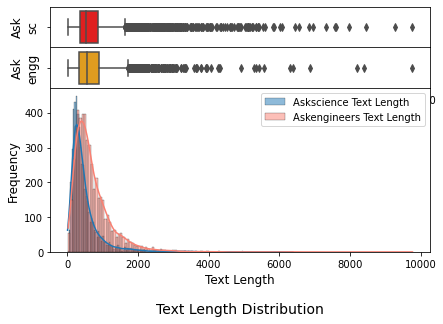

In [178]:
#Text length distibution for the two categories

plt.figure(figsize=(25,15))
figure, ax = plt.subplots(3,1, gridspec_kw={'height_ratios':[1,1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(3,1,3)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['title_st_length'], 
             label='Askscience Text Length', 
             kde=True,
            alpha=.5)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['title_st_length'], 
             label='Askengineers Text Length', 
             kde=True,
            color='salmon')
ax[0].set_title('Text Length Distribution', fontsize=14,y=-0.5, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('Text Length', size=12);
ax[0].legend()

#Boxplots
ax[1]=plt.subplot(3,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['title_st_length'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12)
ax[2]=plt.subplot(3,1,2)
ax[2]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['title_st_length'],color='orange');
ax[2].set_ylabel('Ask\nengg', size=12)


plt.subplots_adjust(hspace=0);

#plt.tight_layout()
#plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
#plt.savefig('../Images/average_ACT_composite_distn.png');


#print('Median' + str(act_sat_merged_2019['act_composite'].median()))
#print('Lower quartile ' + str(np.percentile(act_sat_merged_2019['act_composite'], 25)))
#print('Higher quartile ' + str(np.percentile(act_sat_merged_2019['act_composite'],75)))



It is interesting to note from the above plot that there are much higher counts for longer texts for the posts from 'AskEngineers' subreddit. The boxplots show considerable outliers in terms of the length of posts. 

<Figure size 1800x1080 with 0 Axes>

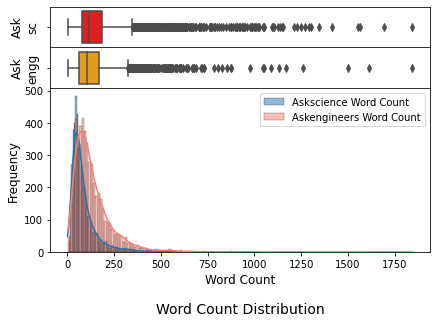

In [179]:
#Word_count distibution for the two categories

plt.figure(figsize=(25,15))
figure, ax = plt.subplots(3,1, gridspec_kw={'height_ratios':[1,1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(3,1,3)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['title_st_word_count'], 
             label='Askscience Word Count', 
             kde=True,
            alpha=.5)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['title_st_word_count'], 
             label='Askengineers Word Count', 
             kde=True,
            color='salmon')
ax[0].set_title('Word Count Distribution', fontsize=14,y=-0.5, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('Word Count', size=12);
ax[0].legend()

#Boxplots
ax[1]=plt.subplot(3,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['title_st_word_count'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12)
ax[2]=plt.subplot(3,1,2)
ax[2]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['title_st_word_count'],color='orange');
ax[2].set_ylabel('Ask\nengg', size=12)


plt.subplots_adjust(hspace=0);

The figure above shows word count distribution for the two categories, as expected, similar to length distribution.

Deciding to drop the rows that are outliers for word count.

In [180]:

q1_asksc_wc=ask_df[ask_df['subreddit']==1]['title_st_word_count'].quantile(0.25)
q3_asksc_wc=ask_df[ask_df['subreddit']==1]['title_st_word_count'].quantile(0.75)
iqr_asksc_wc=q3_asksc_wc-q1_asksc_wc
ask_df.drop(ask_df[(ask_df['title_st_word_count']>(q3_asksc_wc+1.5*iqr_asksc_wc)) & (ask_df['subreddit']==1)].index, inplace=True)


q1_askengg_wc=ask_df[ask_df['subreddit']==0]['title_st_word_count'].quantile(0.25)
q3_askengg_wc=ask_df[ask_df['subreddit']==0]['title_st_word_count'].quantile(0.75)
iqr_askengg_wc=q3_askengg_wc-q1_askengg_wc
ask_df.drop(ask_df[(ask_df['title_st_word_count']>(q3_askengg_wc+1.5*iqr_askengg_wc)) & (ask_df['subreddit']==0)].index, inplace=True)

In [181]:
ask_df.shape

(8876, 11)

In [182]:
ask_df.head(1)

created_utc      id      author  num_comments  score  \
0   1663962461  xm7a6n  bmarcus128             0      1   

                                                                                                                                                                                                                                                                                 selftext  \
0  My typical body temperature hovers around 97.8 F. I'm recovering from COVID, and my temperature is currently about 98.8 F. Do I have a fever? (In other words, is a fever an elevated temperature compared to an individual's baseline or is it a temperature above a certain number?)   

   subreddit  \
0          1   

                                                              title  \
0  Does 98.6 Count as a Fever if Your Average Body Temp Trends Low?   

                                                                                                                                                                                                                                                                                                                                                           title_st  \
0  does  floatnum  count as a fever if your average body temp trends low my typical body temperature hovers around  floatnum  f i am recovering from covid and my temperature is currently about  floatnum  f do i have a fever in other words is a fever an elevated temperature compared to an individuals baseline or is it a temperature above a certain number   

   title_st_length  title_st_word_count  
0              352                   68

**No of authors in each category**

In [183]:
#checking unique no. of users in each category
print(f'No of authors in AskScience:')
print(len(ask_df[ask_df['subreddit']==1]['author'].unique()))
print(f'No of authors in AskEngineers:')
len(ask_df[ask_df['subreddit']==0]['author'].unique())

No of authors in AskScience:
4052
No of authors in AskEngineers:


3555

**No. of authors that are common in two categories**

In [184]:
#No. of authors that are common in both Ask Science and Ask Engineers subreddits
len([1 for x in ask_df[ask_df['subreddit']==1]['author'] if x in ask_df[ask_df['subreddit']==0]['author']])

0

**Subreddit submission activity analysis and comparision**

In [185]:
ask_df[ask_df['subreddit']==1].describe()

created_utc  num_comments         score  subreddit  title_st_length  \
count  4.438000e+03   4438.000000   4438.000000     4438.0      4438.000000   
mean   1.530212e+09     38.599144    250.626183        1.0       386.478594   
std    3.571387e+07    144.039955   1632.594402        0.0       219.330296   
min    1.503986e+09      0.000000      0.000000        1.0        11.000000   
25%    1.510296e+09      4.000000      2.000000        1.0       223.000000   
50%    1.516446e+09      7.000000      5.000000        1.0       332.500000   
75%    1.522132e+09     14.000000     12.750000        1.0       497.000000   
max    1.663962e+09   2523.000000  65836.000000        1.0      1219.000000   

       title_st_word_count  
count          4438.000000  
mean             70.098468  
std              39.062942  
min               1.000000  
25%              41.000000  
50%              61.000000  
75%              90.750000  
max             193.000000

In [186]:
ask_df[ask_df['subreddit']==0].describe()

created_utc  num_comments        score  subreddit  title_st_length  \
count  4.438000e+03   4438.000000  4438.000000     4438.0      4438.000000   
mean   1.656301e+09      0.010140     1.000225        0.0       625.583596   
std    3.743580e+06      0.212598     0.054128        0.0       371.176139   
min    1.650608e+09      0.000000     0.000000        0.0        26.000000   
25%    1.653087e+09      0.000000     1.000000        0.0       342.000000   
50%    1.655758e+09      0.000000     1.000000        0.0       541.000000   
75%    1.659310e+09      0.000000     1.000000        0.0       833.750000   
max    1.664346e+09     10.000000     3.000000        0.0      1835.000000   

       title_st_word_count  
count          4438.000000  
mean            117.537855  
std              70.135210  
min               3.000000  
25%              64.000000  
50%             101.000000  
75%             159.000000  
max             328.000000

Some of the interesting observations from above statistical information are:
1. The range of created UTC (max-min) for same no. of posts is small for AskEngineers subreddit compared to AskScience, indicating more posts with selftext per hour for ASkEngineers compared to AskScience. (This could also mean authors in AskScience dont like to write much self text in their submissions.)

In [187]:
print(f"AskEngineers created UTC min:{ask_df[ask_df['subreddit']==0]['created_utc'].min()}")
print(f"AskEngineers created UTC max: {ask_df[ask_df['subreddit']==0]['created_utc'].max()}")

print(f"AskScience created UTC min:{ask_df[ask_df['subreddit']==1]['created_utc'].min()}")
print(f"AskScience created UTC max: {ask_df[ask_df['subreddit']==1]['created_utc'].max()}")

AskEngineers created UTC min:1650608262
AskEngineers created UTC max: 1664345968
AskScience created UTC min:1503986316
AskScience created UTC max: 1663962461


Converting Epoch time range to hours, it appears that there is 1 post/hour with Selftext for AskEngineers whereas 1 post every 10hours for Ask Science.

    2. Average word count per post (including title and Selftext) is 70 for a submission in AskScience whereas it is 118 for AskEngineers.

<Figure size 1800x1080 with 0 Axes>

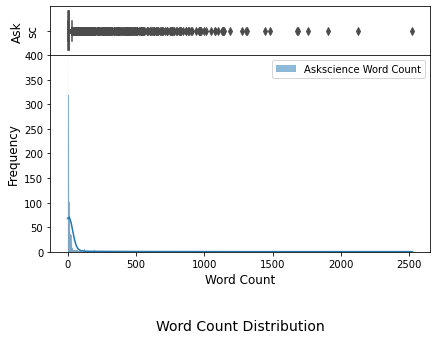

In [197]:
#Distibution of no. of comments for the two categories

plt.figure(figsize=(25,15))
figure, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(2,1,2)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==1]['num_comments'], 
             label='Askscience No. Comments', 
             kde=True,
            alpha=.5)

ax[0].set_title('No. Comments Distribution', fontsize=14,y=-0.5, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('No. Comments', size=12);
ax[0].legend()
plt.ylim(0,400)

#Boxplots
ax[1]=plt.subplot(2,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==1]['num_comments'],color='red');
ax[1].set_ylabel('Ask\nsc', size=12);


plt.subplots_adjust(hspace=0);

<Figure size 1800x1080 with 0 Axes>

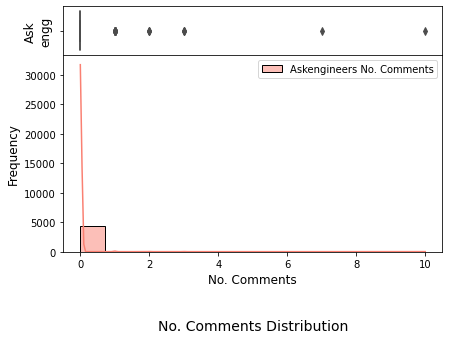

In [199]:
#Distibution of no. of comments for the two categories

plt.figure(figsize=(25,15))
figure, ax = plt.subplots(2,1, gridspec_kw={'height_ratios':[1,4]})
figure.tight_layout()

#Distribution plots
ax[0]=plt.subplot(2,1,2)
ax[0]=sns.histplot(ask_df[ask_df['subreddit']==0]['num_comments'], 
             label='Askengineers No. Comments', 
             kde=True,
            color='salmon')
ax[0].set_title('No. Comments Distribution', fontsize=14,y=-0.5, pad=20)
ax[0].set_ylabel('Frequency', size=12)
ax[0].set_xlabel('No. Comments', size=12);
ax[0].legend()

#Boxplots
ax[1]=plt.subplot(2,1,1)
ax[1]=sns.boxplot(x=ask_df[ask_df['subreddit']==0]['num_comments'],color='orange');
ax[1].set_ylabel('Ask\nengg', size=12)


plt.subplots_adjust(hspace=0);

**Lemmatization**

In [201]:
nlp=spacy.load('en_core_web_md')

In [202]:
ask_df['title_st_lemma']=ask_df['title_st'].map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

**Removing Stop words**

In [216]:
ask_df['title_st_lemma']=ask_df['title_st_lemma'].map(lambda x: ' '.join([token.text for token in nlp(x) if token.is_stop==False ]))

In [335]:
#Saving ask_df as csv
ask_df.to_csv('./datasets/master_data.csv',index=False)

**Defining X, y and Train Test Split**

In [221]:
X=ask_df['title_st_lemma']
y=ask_df['subreddit']

In [226]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42, stratify=y)

In [227]:
X_train.shape,y_train.shape

((6657,), (6657,))

In [228]:
X_test.shape,y_test.shape

((2219,), (2219,))

In [334]:
pd.DataFrame(X_train)

title_st_lemma
1734                                                                                                                                                                                                                                                                                                                                                                                                                                                       reliable rivnut quest project car need stick captive nut car secure    subframe mount option    standard steel bolt thread block weld body bolt thread blockthreade simple effective way probably history bolt thing option    use rivnut know rivnut perfect profile application find datum reliable strong sure safe use secure subframe car subframe hold motor gearbox
1309                                                                                                                                                                                                                                                    trouble long lunch break supervisor message expect work    hour    hour lunch    negativenum    flexible time day tell    negativenum       minute lunch lunch usually try lose weight stay busy work eat distract hunger tell need available workload require sure work ask outright issue work try stuff ahead deadline issue tell willing work    hour deadline require work    hour leave approachingimmediate deadline boss stingy politely tell need available    negativenum    regardless long lunch relatively new boss claim flexible    hour work input appreciate
3681                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 electric car way efficient multiple gear imagine electric motor save power simply run slow speed
4913                                                                                                                                                                                                                                                                                                                                                                calculation lift structural member shorten rigging lift crane load cog position beneath hook place sling center gravity sling equidistant center gravity lift load horizontally purposefully lift steel angle eg rafter    pitch help position pin sling away cog lighter shorten chain curious calculate angle lift load presume featureless steel beam       leg chain sling location relation cog chain differ length scenario curious calculate tension sling
1330                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   tactfully convey colleague need stick word annoying colleague    lot excuse tell thing like want good expert opinion produce work set meeting happen time guy basically talker doer different mana

**EDA on most frequent words**

In [232]:
cvec=CountVectorizer()
X_train_cvec=cvec.fit_transform(X_train)

In [233]:
X_train_cvec.shape

(6657, 18851)

In [244]:
train_df=pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names_out())
train_df['subreddit']=y_train.values

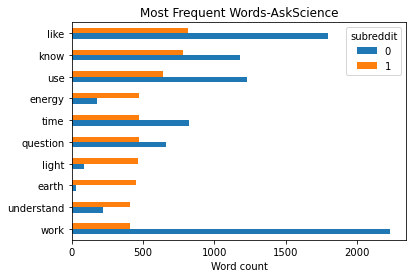

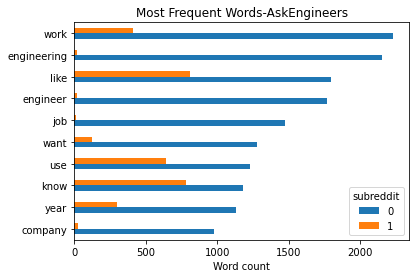

In [251]:
#Most frequent words in subreddit AskScience
train_df.groupby('subreddit').sum().T.sort_values(1,ascending=True).tail(10).plot(kind='barh')
plt.title('Most Frequent Words-AskScience')
plt.xlabel('Word count')
plt.show()

#Most frequent words in subreddit AskEngineers
train_df.groupby('subreddit').sum().T.sort_values(0,ascending=True).tail(10).plot(kind='barh')
plt.title('Most Frequent Words-AskEngineers')
plt.xlabel('Word count')
plt.show()

The plots above show most frequent words for subreddits AskScience and AskEngineers. It is to be noted that overall the total word count for most frequent words is much higher in AskEngineers indicating that there is much  more text data for subreddit AskEngineers than AskScience.

**Unique words**

In [280]:
train_df_words=train_df.groupby('subreddit').sum().T
train_df_words.reset_index(inplace=True)
train_df_words.columns=['Word','Engg count','Sc count']
train_df_words.sample(3, random_state=42)


Word  Engg count  Sc count
3106   competition          13         2
6415       foolish           0         1
13905     relation          12        13

In [305]:
#number of unique words in subreddit AskEngineers
engg_unique_wordc=train_df_words['Engg count'].value_counts().head(1)
print(f"Unique word count AskEngineers: {engg_unique_wordc}")

#number of unique words in subreddit AskScience
sc_unique_wordc=train_df_words['Sc count'].value_counts().head(1)
print(f"Unique word count AskEngineers: {sc_unique_wordc}")


Unique word count AskEngineers: 0    6251
Name: Engg count, dtype: int64
Unique word count AskEngineers: 0    7376
Name: Sc count, dtype: int64


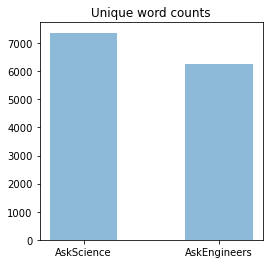

In [306]:
plt.figure(figsize=(4,4))
plt.bar(['AskScience','AskEngineers'],[7376,6251],
       width=0.5,alpha=0.5)
plt.title('Unique word counts');

In [330]:
#Unique words in the two subreddits
unique_words=pd.DataFrame()
unique_words['AskScience']=train_df_words[train_df_words['Engg count']==0].sort_values('Sc count', ascending=False).Word.head(10).copy()
unique_words.reset_index(inplace=True, drop=True)
unique_words['AskEngineers']=train_df_words[train_df_words['Sc count']==0].sort_values('Engg count', ascending=False).reset_index().Word.head(10).copy()
unique_words

AskScience AskEngineers
0        vaccine   internship
1          virus        civil
2            ama           ee
3         immune           mm
4            flu       pursue
5            dna       resume
6         proton    recruiter
7  gravitational          cad
8       antibody   contractor
9        nucleus        shaft

The above table lists most frequent 10 unique words in the two subreddits. The words in AskScience are more medicine/biology related like vaccine, virus etc, whereas AskEngineers has wrds like civil,ee,units-mm etc.

In [214]:
askengineers_df_clean['title_st'].sample()

5043    how do i connect this handle to my electric scooter hi i want to install a new handlebar on my electric bird  electric scooter the holes for the original handlebar are too small to fit the big handlebar i could drill them bigger but then i would not be able to mount them using the original clamps my other idea was to remove everything from the original handle and mount the  handlebars using some kind of clamps or something else to secure them in place here is a picture so you have a visualization of what i mean picture  drawing  do you guys know any good clamp for  different diameters to connect them together or if you have a better way of doing this please let me know thank you in advance
Name: title_st, dtype: object

In [205]:
doc=st.iloc[1730,0]

NameError: name 'st' is not defined

In [206]:
doc

NameError: name 'doc' is not defined

In [137]:
ex = nlp(doc)
print(ex.text)

I tried to ask ELI5 to help me understand Sabrina Pasterski’s discoveries, as they’re a bit over my head, but was told this might be a more reliable place for information. I’m specifically interested in the  Pasterski-Strominger-Zhiboedov Triangle and it’s potential importance, relevance, and application. I know it ties into black holes, the difference between 2, 3, and 4 dimensions, and it sounds like it lends support to theories put forth by Weinberg. But it’s so far more advanced than I can grasp right now. Even the stuff I think I understand could very well be wrong. Would anybody care to use some layman’s terms to help me grasp these concepts Thank you!


In [ ]:
ex.